In [143]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt

In [144]:
main_folder = "C:/Users/Rostom/Videos/5SDBD/Projet_Intégrateur/archive/"
ATTR_PATH = main_folder + "list_attr_celeba.csv"  # contains the image attributes (Male, Smiling, Young, ...)
PARTITION_PATH = main_folder + "list_eval_partition.csv"  # contains the recommended partitioning of images into training, validation and testing sets.
IMAGES_PATH = main_folder + "img_align_celeba/img_align_celeba/"  # contains the .jpg images

#BATCH_SIZE = 128  # try a smaller batch size if you have limited computational resources
BATCH_SIZE = 64
MODEL_HANDLE = "./model"  # we use this pretrained model to obtain a feature vector from each image
IMAGE_SIZE = (220, 220)  # input size required by our pretrained model

In [145]:
df = pd.merge(pd.read_csv(PARTITION_PATH), pd.read_csv(ATTR_PATH), on="image_id")
df.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,0,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,0,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,0,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,0,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [146]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, male, smiling, young, attractive):
    images = load_and_preprocess_image(path)
    return images, male, smiling, young, attractive

def build_dataset_from_df(df):
    ds = tf.data.Dataset.from_tensor_slices((
        [IMAGES_PATH + image_id for image_id in df["image_id"]],
        list(df["Male"].replace(-1, 0)),
        list(df["Smiling"].replace(-1, 0)),
        list(df["Young"].replace(-1, 0)),
        list(df["Attractive"].replace(-1, 0))
    ))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [147]:
train_df = df.loc[df["partition"] == 0].head(1000)
# if you're in a rush, add: train_df = train_df.sample(n=5000)
train_ds = build_dataset_from_df(train_df)

val_df = df.loc[df["partition"] == 1].head(200)
# if you're in a rush, add: val_df = val_df.sample(n=1000)
val_ds = build_dataset_from_df(val_df)

In [148]:
for image, male, smiling, young, attractive in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label gender: ", male.shape)
    print("Label smiling: ", smiling.shape)
    print("Label young: ", young.shape)
    print("Label attractive: ", attractive.shape)

Image shape:  (64, 220, 220, 3)
Label gender:  (64,)
Label smiling:  (64,)
Label young:  (64,)
Label attractive:  (64,)


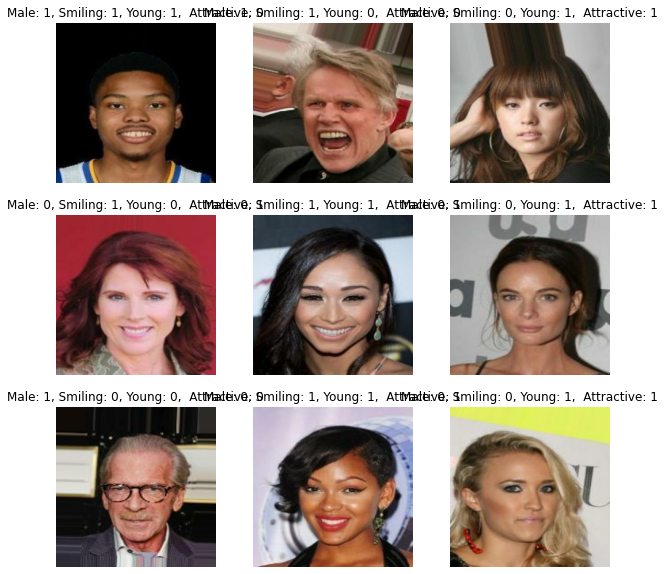

In [149]:
image, male, smiling, young, attractive = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    s = f"Male: {male[i].numpy()}, Smiling: {smiling[i].numpy()}, Young: {young[i].numpy()},  Attractive: {attractive[i].numpy()}"
    plt.title(s)
    plt.axis("off")

In [150]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, male, smiling, young, attractive:
                        (preprocessing_model(images), (male, smiling, young, attractive)))

val_ds = val_ds.map(lambda images, male, smiling, young, attractive:
                    (normalization_layer(images), (male, smiling, young, attractive)))

In [151]:
do_fine_tuning = False
input = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = hub.KerasLayer(MODEL_HANDLE, trainable=do_fine_tuning)(input)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

out_male = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='male')(x)
out_smiling = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='smiling')(x)
out_young = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='young')(x)
out_attractive = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='attractive')(x)


model = tf.keras.Model( inputs = input, outputs = [out_male, out_smiling, out_young, out_attractive])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer_3 (KerasLayer)     (None, 1280)         5919312     ['input_4[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 1280)         0           ['keras_layer_3[0][0]']          
                                                                                                  
 dense_3 (Dense)                (None, 128)          163968      ['dropout_3[0][0]']        

In [152]:
model.compile(
    loss = {
        "male": tf.keras.losses.BinaryCrossentropy(),
        "smiling": tf.keras.losses.BinaryCrossentropy(),
        "young": tf.keras.losses.BinaryCrossentropy(),
        "attractive": tf.keras.losses.BinaryCrossentropy()
    },
    metrics = {
        "male": 'accuracy',
        "smiling": 'accuracy',
        "young": 'accuracy',
        "attractive": 'accuracy'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [153]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3
15/15 [==============================] - 33s 2s/step - loss: 2.1695 - male_loss: 0.3989 - smiling_loss: 0.6990 - young_loss: 0.4674 - attractive_loss: 0.6035 - male_accuracy: 0.8073 - smiling_accuracy: 0.5813 - young_accuracy: 0.7979 - attractive_accuracy: 0.6979 - val_loss: 1.8771 - val_male_loss: 0.2333 - val_smiling_loss: 0.6090 - val_young_loss: 0.4098 - val_attractive_loss: 0.6243 - val_male_accuracy: 0.9010 - val_smiling_accuracy: 0.7188 - val_young_accuracy: 0.8385 - val_attractive_accuracy: 0.6823
Epoch 2/3
15/15 [==============================] - 30s 2s/step - loss: 1.5605 - male_loss: 0.1536 - smiling_loss: 0.5546 - young_loss: 0.3923 - attractive_loss: 0.4592 - male_accuracy: 0.9375 - smiling_accuracy: 0.7229 - young_accuracy: 0.8260 - attractive_accuracy: 0.7906 - val_loss: 1.7554 - val_male_loss: 0.1610 - val_smiling_loss: 0.5356 - val_young_loss: 0.4190 - val_attractive_loss: 0.6391 - val_male_accuracy: 0.9323 - val_smiling_accuracy: 0.7708 - val_young_accuracy:

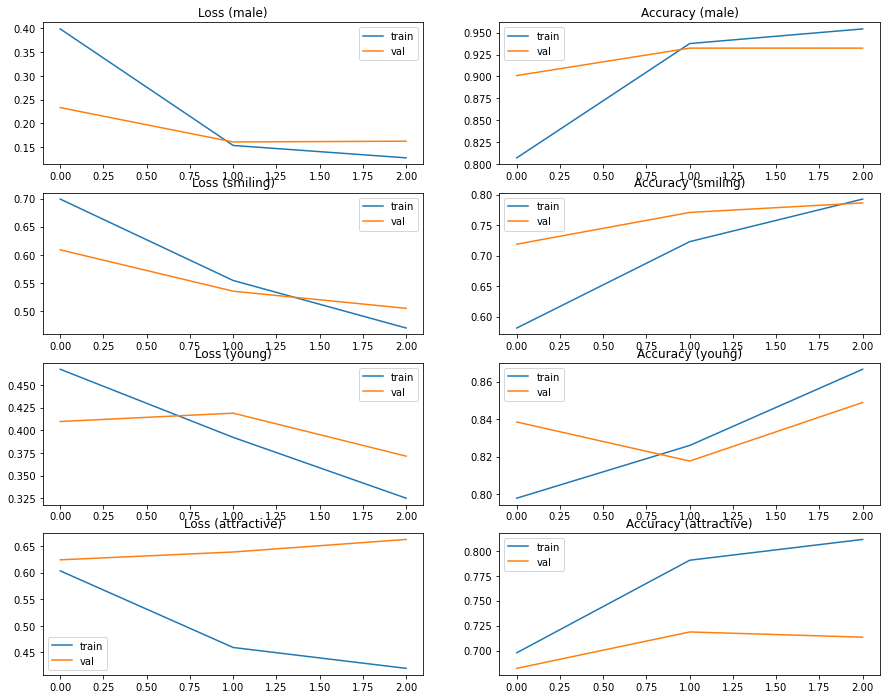

In [154]:
fig, ax = plt.subplots(4, 2, figsize=(15, 12))
for i, c in enumerate(["male", "smiling", "young", "attractive"]):
    ax[i, 0].plot(hist[f"{c}_loss"], label="train")
    ax[i, 0].plot(hist[f"val_{c}_loss"], label="val")
    ax[i, 0].set_title(f"Loss ({c})")
    ax[i, 0].legend()
    ax[i, 1].plot(hist[f"{c}_accuracy"], label="train")
    ax[i, 1].plot(hist[f"val_{c}_accuracy"], label="val")
    ax[i, 1].set_title(f"Accuracy ({c})")
    ax[i, 1].legend()
plt.show()

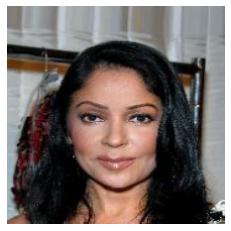

1/1 [==============================] - 1s 723ms/step
Male: actual 0, predicted 0 (0.0058)
Smiling: actual 0, predicted 1 (0.8253)
Young: actual 1, predicted 1 (0.9788)
Attractive: actual 1, predicted 1 (0.6584)


In [155]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(["Male", "Smiling", "Young", "Attractive"]):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

In [156]:
#from keras.utils import plot_model
#model.summary()

In [157]:
def open_images(inference_folder: str) -> np.ndarray:
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  # create full path to image

        with Image.open(img_location) as img:  # open image with pillow

            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net

        images.append(img)
    images_array = np.vstack(images)  # combine images efficiently to a numpy array
    return images_array

In [158]:
from PIL import Image
import os, sys

path = "./image_samples/"
dirs = os.listdir( path )
resized_path = "./images_resized/"

def resize():
    for item in dirs:
        print(item)
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            im = im.convert('RGB')
            f, e = os.path.splitext(path+item)
            imResize = im.resize((220,220), Image.ANTIALIAS)
            imResize.save(resized_path + item + '_resized.jpg', 'JPEG', quality=90)
            #imResize.save(resized_path + '_resized.jpg', 'JPEG', quality=90)

resize()

jean.jpg
souhail.jpg


2
<class 'numpy.ndarray'>


AttributeError: module 'numpy' has no attribute 'expana_dims'

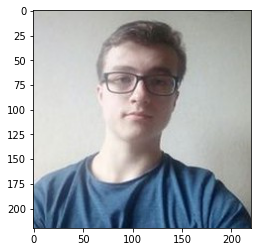

In [166]:
import os
from PIL import Image
#type(open_images("./image_samples/"))
#print(image) 
image2 = open_images(resized_path)
print(len(image2))
#print(image2)
image3=image2[0]
image4=image2[1]
image3
plt.imshow(image3)
print(type(image3))
prediction_score3= model.predict(np.expana_dims(image3, axis=0))
prediction_score4= model.predict(np.expand_dims(image4, axis=0))

In [160]:
prediction_score3
for i, label in enumerate(["Male", "Smiling", "Young", "Attractive"]):
    pred = prediction_score3[i][0][0]
    print(f"{label}: predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

Male: predicted 0 (0.0000)
Smiling: predicted 0 (0.0000)
Young: predicted 1 (1.0000)
Attractive: predicted 0 (0.0000)


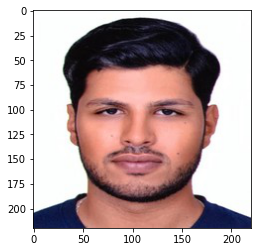

In [161]:
plt.imshow(image4)

In [162]:
prediction_score4
for i, label in enumerate(["Male", "Smiling", "Young", "Attractive"]):
    pred2 = prediction_score4[i][0][0]
    print(f"{label}: predicted {1 if pred2 > 0.5 else 0} ({format(pred2, '.4f')})")

Male: predicted 1 (1.0000)
Smiling: predicted 0 (0.0000)
Young: predicted 1 (1.0000)
Attractive: predicted 1 (1.0000)


In [163]:
prediction_score3

[array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32)]